In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
# Predict the life expectancy of a newborn based on several attributes (features) related to the region which he/she was born in.

In [3]:
# Import Dataset
life_expectancy_train_dataset = "s3://rmit-ml-2020s1-lab-data/Assignment1_data/train.csv"
life_expectancy_test_dataset = "s3://rmit-ml-2020s1-lab-data/Assignment1_data/test.csv"

In [4]:
# Set Dataframes
le_train_DF = pd.read_csv(life_expectancy_train_dataset)
le_test_DF = pd.read_csv(life_expectancy_test_dataset)

ID                                 AxesSubplot(0.125,0.772143;0.110714x0.107857)
TARGET_LifeExpectancy           AxesSubplot(0.257857,0.772143;0.110714x0.107857)
Country                         AxesSubplot(0.390714,0.772143;0.110714x0.107857)
Year                            AxesSubplot(0.523571,0.772143;0.110714x0.107857)
Status                          AxesSubplot(0.656429,0.772143;0.110714x0.107857)
AdultMortality                  AxesSubplot(0.789286,0.772143;0.110714x0.107857)
AdultMortality-Male                AxesSubplot(0.125,0.642714;0.110714x0.107857)
AdultMortality-Female           AxesSubplot(0.257857,0.642714;0.110714x0.107857)
InfantDeaths                    AxesSubplot(0.390714,0.642714;0.110714x0.107857)
Alcohol                         AxesSubplot(0.523571,0.642714;0.110714x0.107857)
PercentageExpenditure           AxesSubplot(0.656429,0.642714;0.110714x0.107857)
Measles                         AxesSubplot(0.789286,0.642714;0.110714x0.107857)
BMI                         

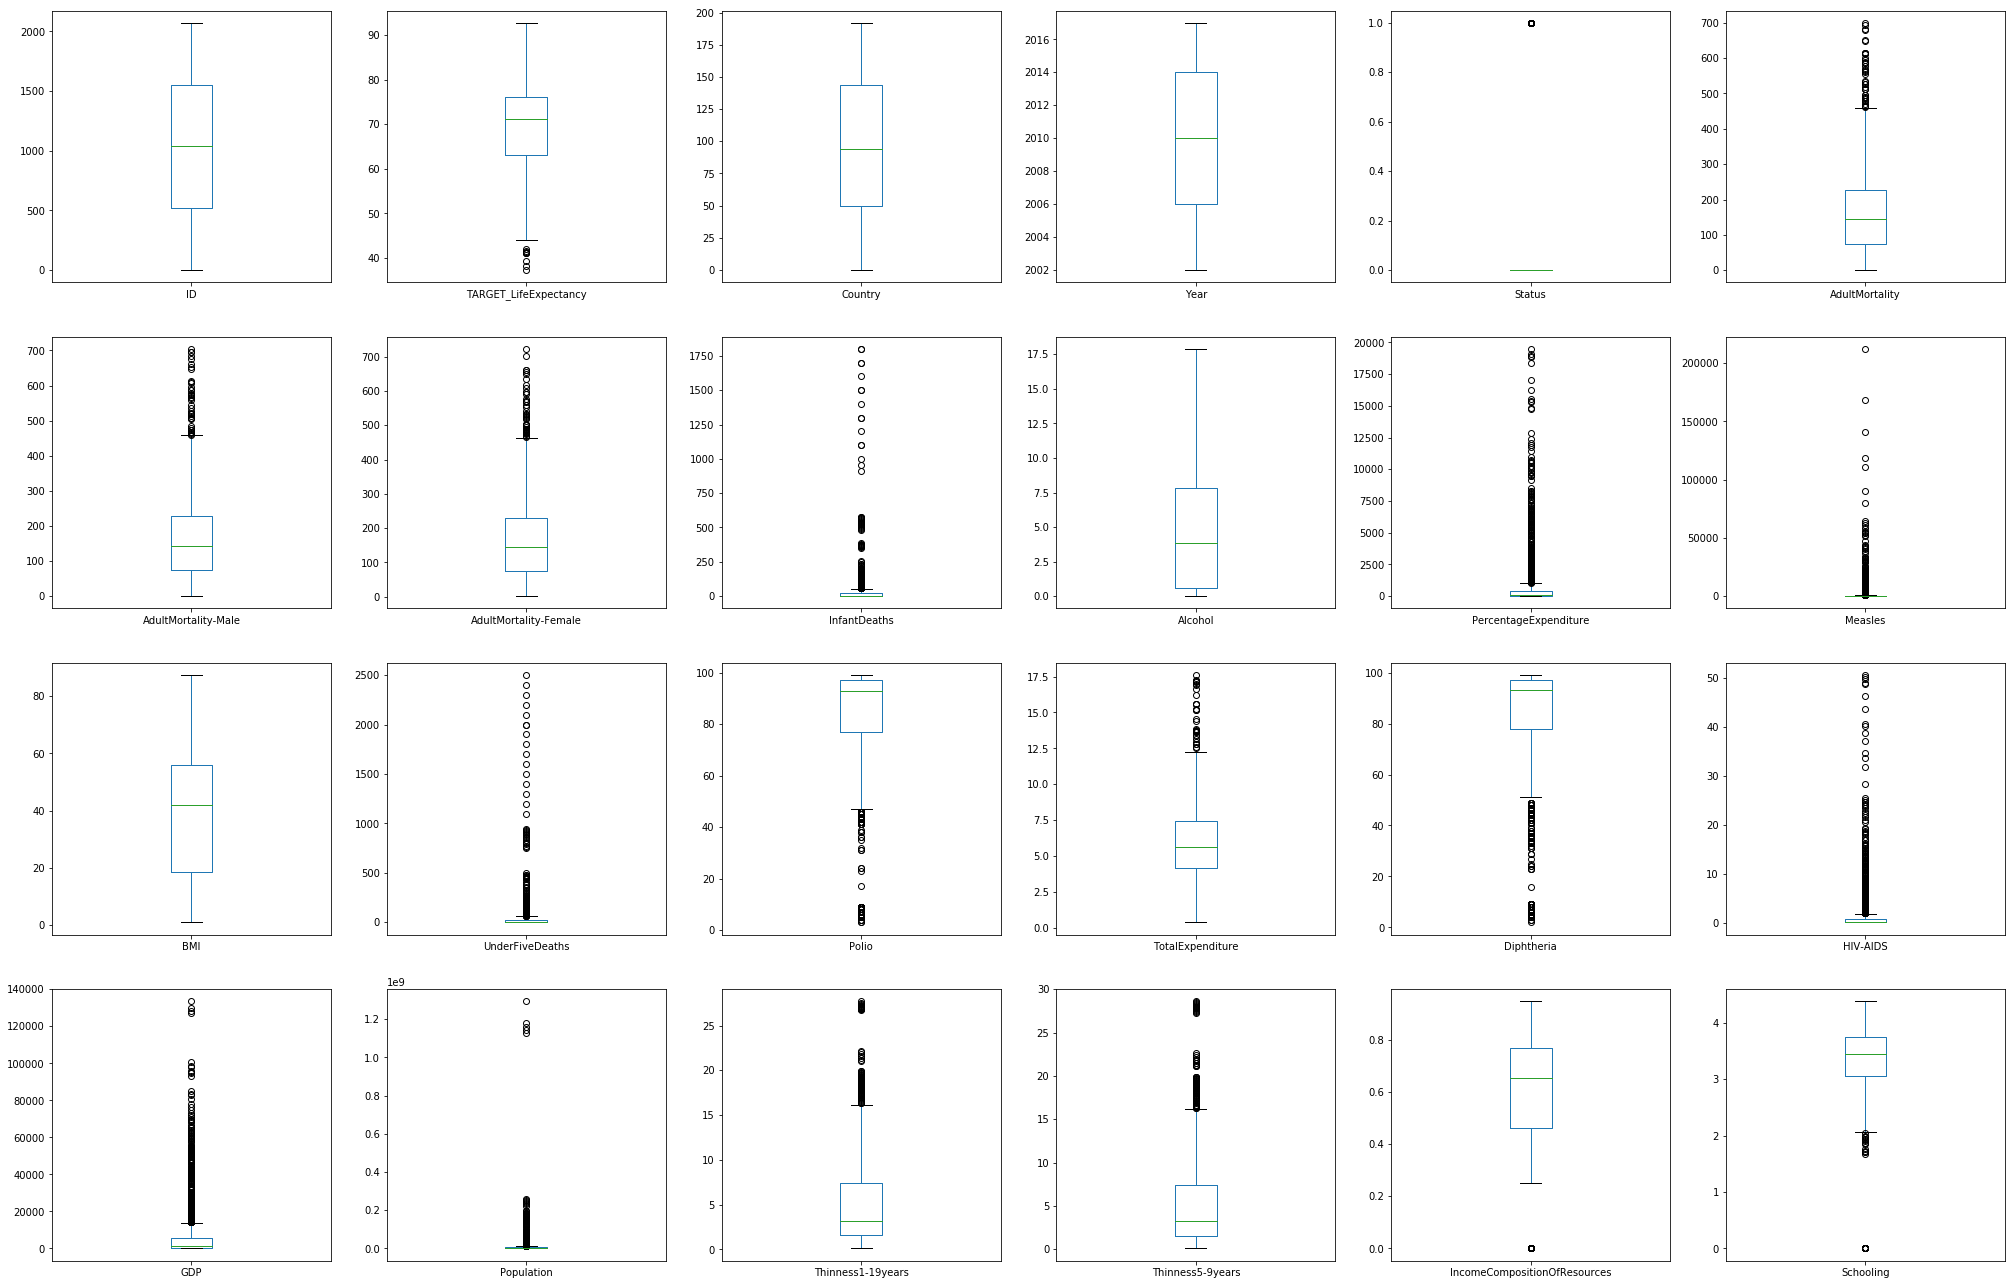

In [5]:
# Analysis of Data

# Box Plot to find the outliers within the dataset
le_train_DF.plot(kind="box", subplots=True, layout=(6,6),
                sharex=False, sharey=False, figsize=(35,35))


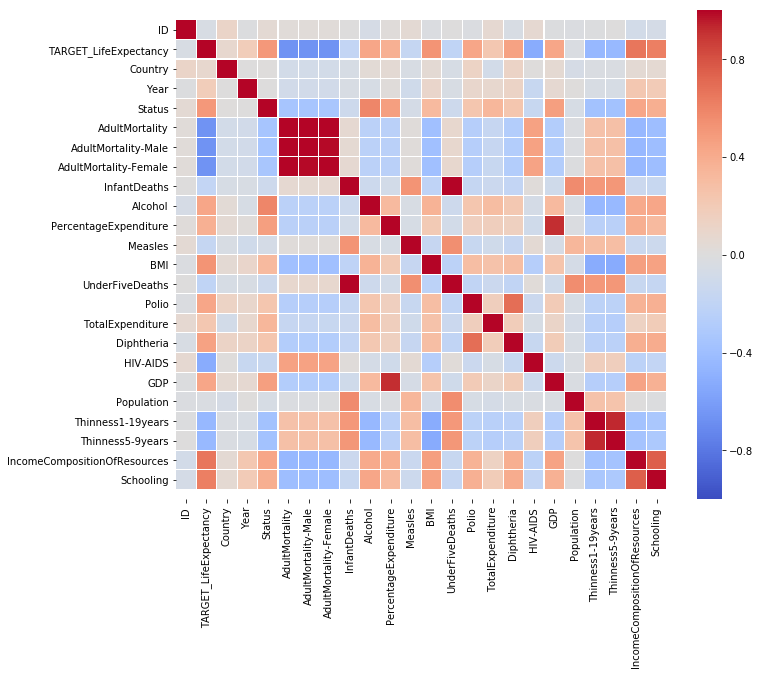

In [6]:
# Analysis- Correlation Heat Map
import seaborn as sns

correlations = le_train_DF.corr()

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(round(correlations,2), ax=ax, cmap="coolwarm", vmin=-1, vmax=1, fmt='.2f', linewidths=.05)
b, t = plt.ylim() 
b += 0.5
t -= 0.5 
plt.ylim(b, t) 
plt.show()

In [7]:
#
#Normalise the data, using mean normalisation method
#Through the analysis, it has been observed on the box plots that there are significant outliers.
#Min Max Scaling does not handle outliers very well, so mean normalisation has been chosen instead
#
independent_scaler = preprocessing.StandardScaler()
target_scaler = preprocessing.StandardScaler()

# Set X as all independent variables (minus TARGET_LifeExpectancy)
X_train_DF = le_train_DF.iloc[:, 2:]
X_test_DF = le_test_DF.iloc[:, 1:]

# Set Y as dependent variable 'TARGET_LifeExpectancy'
Y_train_DF = le_train_DF['TARGET_LifeExpectancy']

# Convert into Array to manipulate
X_train_values = X_train_DF.values
Y_train_values = Y_train_DF.values
X_test_values = X_test_DF.values

X_train_values_scaled = independent_scaler.fit_transform(X_train_values)
Y_train_values_scaled = target_scaler.fit_transform(Y_train_values.reshape(-1, 1))
X_test_values_scaled = independent_scaler.fit_transform(X_test_values)

X_train = pd.DataFrame(X_train_values_scaled, columns=X_train_DF.columns)
Y_train = pd.DataFrame(Y_train_values_scaled)
X_test = pd.DataFrame(X_test_values_scaled, columns=X_test_DF.columns)

In [8]:
# Configure KFold settings
from sklearn import model_selection
number_splits = 10
kFold = model_selection.KFold(n_splits=number_splits, shuffle=True)

In [9]:
# Split the train.csv into 80/20 split into a training set (80%) to testing set(20%)
from sklearn.model_selection import train_test_split

train_X, test_X = train_test_split(X_train, test_size=0.2, shuffle = False)
train_Y, test_Y = train_test_split(Y_train, test_size=0.2, shuffle = False)

Text(0, 0.5, 'Average R-Score')

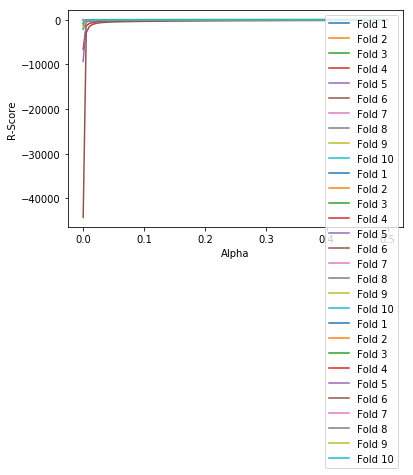

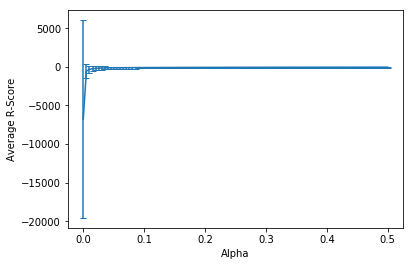

In [10]:
# Splitting Training and Validation set, via KFold Method
lRegPara = np.linspace(0.0001,0.5,num=100)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
lResults = np.zeros((number_splits,len(lRegPara)))
best_r2_perDegree= []
alpha_results = {}
r2_results = []

# Determine optimal Polynomial Regression degree
for i in range(1, 4):
    polyFeat = PolynomialFeatures(degree=i, include_bias=True)
    nsplit = 0
    lResults = np.zeros((number_splits, len(lRegPara)))
    
    # Cross Validate differing values of alpha for Lasso Regression
    for trainIndex, validIndex in kFold.split(train_X):

        # Get the training and validation data
        trainX = np.array(train_X.loc[trainIndex])
        trainY = np.array(train_Y.loc[trainIndex])
        validX = np.array(train_X.loc[validIndex])
        validY = np.array(train_Y.loc[validIndex])
        
        # Fit Polynomial Model
        polyFitTrainX = polyFeat.fit_transform(trainX)
        polyFitValidX = polyFeat.fit_transform(validX)

        for j, regPara in enumerate(lRegPara):
            polyLassoReg = linear_model.Ridge(alpha=regPara, normalize=False, tol=0.1)
            model = polyLassoReg.fit(polyFitTrainX, trainY) # Train model with above configuration
            predY = polyLassoReg.predict(polyFitValidX) 
            r2 = r2_score(validY, predY, multioutput='raw_values') 
            alpha_results[str(r2)] = (regPara)
            r2_results.append((r2))
            lResults[nsplit, j] = (r2)
        
        plt.plot(lRegPara, lResults[nsplit, :], label='Fold '+str(nsplit+1))
        nsplit = nsplit + 1
    best_r2_perDegree.append(np.max(r2_results))
    
plt.xlabel("Alpha")
plt.ylabel("R-Score")
plt.legend()

plt.figure()
plt.errorbar(lRegPara, np.mean(lResults,axis=0), yerr=np.std(lResults,axis=0),capsize=3)
plt.xlabel("Alpha")
plt.ylabel("Average R-Score")

Text(0, 0.5, 'Average R-Score')

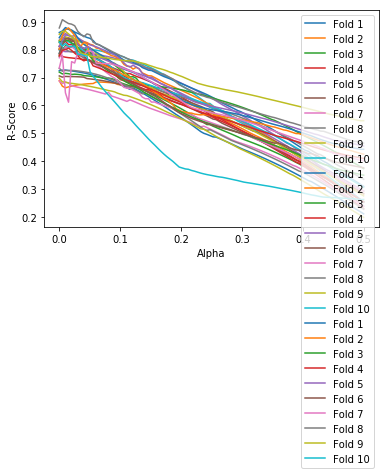

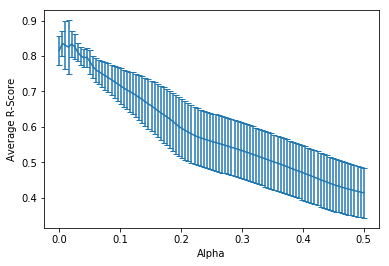

In [11]:
# Splitting Training and Validation set, via KFold Method
lRegPara = np.linspace(0.0001,0.5,num=100)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
lResults = np.zeros((number_splits,len(lRegPara)))
best_r2_perDegree= []
alpha_results = {}
r2_results = []

# Determine optimal Polynomial Regression degree
for i in range(1, 4):
    polyFeat = PolynomialFeatures(degree=i, include_bias=True)
    nsplit = 0
    lResults = np.zeros((number_splits, len(lRegPara)))
    
    # Cross Validate differing values of alpha for Lasso Regression
    for trainIndex, validIndex in kFold.split(train_X):

        # Get the training and validation data
        trainX = np.array(train_X.loc[trainIndex])
        trainY = np.array(train_Y.loc[trainIndex])
        validX = np.array(train_X.loc[validIndex])
        validY = np.array(train_Y.loc[validIndex])
        
        # Fit Polynomial Model
        polyFitTrainX = polyFeat.fit_transform(trainX)
        polyFitValidX = polyFeat.fit_transform(validX)

        for j, regPara in enumerate(lRegPara):
            polyLassoReg = linear_model.Lasso(alpha=regPara, normalize=False, tol=0.1)
            model = polyLassoReg.fit(polyFitTrainX, trainY) # Train model with above configuration
            predY = polyLassoReg.predict(polyFitValidX) 
            r2 = r2_score(validY, predY, multioutput='raw_values') 
            alpha_results[str(r2)] = (regPara)
            r2_results.append((r2))
            lResults[nsplit, j] = (r2)
        
        plt.plot(lRegPara, lResults[nsplit, :], label='Fold '+str(nsplit+1))
        nsplit = nsplit + 1
    best_r2_perDegree.append(np.max(r2_results))
    
plt.xlabel("Alpha")
plt.ylabel("R-Score")
plt.legend()

plt.figure()
plt.errorbar(lRegPara, np.mean(lResults,axis=0), yerr=np.std(lResults,axis=0),capsize=3)
plt.xlabel("Alpha")
plt.ylabel("Average R-Score")

In [14]:
# Determine the optimal paramters for Final Model
best_r2Score = np.around(np.max(best_r2_perDegree), decimals=8)
optimal_polyDegree = best_r2_perDegree.index(np.max(best_r2_perDegree)) + 1
optimal_regPara = alpha_results[str([best_r2Score])]

In [17]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
r2_score_avg = []
#Test final model, with test set
polyFeat = PolynomialFeatures(degree=optimal_polyDegree, include_bias=True)
polyFitTrainX = polyFeat.fit_transform(train_X)
polyFitTestX = polyFeat.fit_transform(test_X)
polyLassoReg = linear_model.Lasso(alpha=optimal_regPara, normalize=False, tol=0.1)

model = polyLassoReg.fit(polyFitTrainX, train_Y)
predY = model.predict(polyFitTestX)
mae = mean_absolute_error(test_Y, predY)
mse = mean_squared_error(test_Y, predY)
r2 = r2_score(test_Y, predY)
r2_score_avg.append(r2)

In [18]:
from IPython.display import FileLink, FileLinks

#Unscale results, and export as CSV
predY_DF = pd.DataFrame(predY)
predY_unscaled = target_scaler.inverse_transform(predY_DF)
predY_DF_unscaled = pd.DataFrame(predY_unscaled)
predY_DF_unscaled
csv = predY_DF_unscaled.to_csv('predictedY.csv', index=False)
r2_avg = np.mean(r2_score_avg)

In [19]:
r2_avg

0.822815981877586